# <span style="color:#0b486b">  FIT5215: Deep Learning (2023)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Tutor:*  **Mr Tuan Nguyen**  \[tuan.ng@monash.edu \] | **Dr Binh Nguyen** \[binh.nguyen1@monash.edu \] | **Dr Qiuhong Ke** \[Qiuhong.Ke@monash.edu  \] 
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">Tutorial 2: Feed-forward Neural Nets with TensorFlow 2.x</span>
**The purpose of this tutorial is to demonstrate how to work with an open source software library for developing deep neural networks apllications, called TensorFlow. In this tutorial, we will focus on**:  
- ***Inspect the common pipeline of deep learning*.**
- ***How to implement a feedforward neural net for a multi-class classfication problem using TF 2.x*.**

***

### <span style="color:#0b486b"> II.1 Feedforward Neural Network </span> <span style="color:red">***** (highly important)</span>
#### <span style="color:#0b486b"> Tutorial objective </span>

In this tutorial we consider a fairly realistic deep NNs with *three* layers plus the *output* layer. Its architecture is specified as: $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLu) \rightarrow 26$, meaning that:
- Input size is 16
- First layer has 10 hidden units with ReLU activation function
- Second layer has 20 hidden units with 20 ReLU activiation function
- Third layer has 15 hidden units with 15 ReLU activiation function
- And output layer is logit layer with 26 hidden units

This network, for example, can take the `letter` dataset input with $16$ features and with $26$ classes (A-Z). **Our objective in this tutorial is to implement this specific network in `TensorFlow 2.x`.**

#### <span style="color:#0b486b">Specifying the Neural Network Architecture </span>

We can visualize this network as in the figure below. Note that for readability, the number of hidden units in the figure might not equal exactly to the actual size of the hidden units used.

<img src="./images/DNN_Pipeline.PNG" width="1000">

Furthermore, the above figure shows the pipeline of the entire process for feeding a mini-batch of batch size $32$ into the network. Using ***mini-batch*** is a common way to train deep NNs in practice.

Let us denote the mini-batch by $X_b= \{(x_1, y_1),\dots, (x_{32}, y_{32})\}$. The mini-batch can be stored using a $2D$ tensor with the shape $(32, 16)$. Assume that in this network, we use the activation function $ReLu$ where $ReLu(t)= \max\{0, t\}$. The computation in the forward propagation step is as follows:
- Input $X_b$ with mini-batch size of 32
- $h_1= ReLu(X_b \times W^1 + b^1)\in \mathbb{R}^{32 \times 10}$. 
- $h_2= ReLu(h_1 \times W^2 + b^2\in \mathbb{R}^{32 \times 20}$. 
- $h_3= ReLu(h_2 \times W^3 + b^3\in \mathbb{R}^{32 \times 15}$. 
- $logits= h_3 \times W^4 + b^4 \in \mathbb{R}^{32 \times 26}$
- $p = softmax(logits) \in \mathbb{R}^{32 \times 26}$ <br>

where we note that the activation function is perfomed element-wise and the softmax function is used to transform a vector of scalars to a discrete distribution as: 

$$softmax(z)=\big[\frac{\exp(z_i)}{\sum_{j=1}^{26}{\exp(z_j)}}\big]_{i=1}^{26}$$

The $k$-th row $p_k$ of the matrix $p$ can represent the probability distribution to classify the data point $x_k$ to the classes $1,2,\dots,26$. In particular, we have:

$$p_{km}= p(y_k=m \mid x_k)  \text{ for }  m=1,2,\dots,26$$

**<span style="color:red"> Exercise 1</span>** : Explain why the dimension for $h_1$ is $32\times 10$? Similarly, please work out the dimension for $h2, h3, logits$ and $p$.

#### <span style="color:#0b486b">Specifying the Loss Function </span>
Essiential to training a deep NN is the concept of the **loss function**. This function tells us how good the network is predicting, and hence we can use this loss to find the network weights in such a way that the loss can be minimized.

For classification task, a common approach is to use the **cross-entropy** loss function. Given a data-label instance $(x_k,y_k)$ where feature $x_k\in \mathbb{R}^{16}$ and the label $y_k \in \{1,2,...,26\}$ is a numeric label (for example if $x_k$ is in the class 2, then $y_k =2 $ and its one-hot vector $1_{y_k}=[0,1,0,...,0]$). The cross-entroty between the classification distribution $p_k$ returned from the NN and true label distribution $y_k$ is defined as:
$$cross\_entropy(1_{y_k}, p_k)=-\sum_{j=1}^{26}y_{kj}\log{p_{kj}}=-\log p_{k,y_k}$$. This loss basically enforces the model to predict the label as close as the true label by minimizing $cross\_entropy(1_{y_k}, p_k)$

The above loss function was applied for each instance. For the entire current mini-batch, our loss function becomes: 
$$\min \sum_{k=1}^{32}cross\_entropy(1_{y_k}, p_k)$$

**<span style="color:red"> Exercise 2: </span>** : **<span style="color:#0b486b">In the corss-entropy equation above, $y_k$ is the class for $x_k$, explain why the end result is $-\log p_{k,y_k}$.</span>**

**<span style="color:red"> Exercise 3: </span>** : **<span style="color:#0b486b">Let $p=[0.1, 0.3, 0.6]$ and $q=[0.0, 0.5, 0.5]$ be two discrete distributions, what is the $cross\_entropy(q,p)$ ?</span>**

### <span style="color:#0b486b"> II.2 Implementation with TensorFlow 2.x</span> <span style="color:red">***** (highly important)</span>
We now shall implement the aforementioned network with the architecture of $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLu) \rightarrow 26$ in Tensorflow using the dataset `letter`. 

This letter dataset can be found at [the LIBSVM website](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#letter). Here is the dataset information:
-  *The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet. The character images were based on 20 different fonts and each letter within these 20 fonts was randomly distorted to produce a file of 20,000 unique stimuli. Each stimulus was converted into 16 primitive numerical attributes (statistical moments and edge counts) which were then scaled to fit into a range of integer values from 0 through 15*

A typical pipeline process of implementing a deep learning model is as follows:

1. **Data processing**: 
    - Load the dataset and split into train, valid, and test sets.  
     
2. **Building the model**: 
    - Build the model using keras layers.
     
3. **Compiling the model**: 
    - Compile the model and specify the optimizer, the loss (e.g., cross-entropy loss) you want to optimize, metrics you want to measure. 
    
4. **Training and evalutating**:
    - Train the model with specific training set and validation set in a number of epochs.
    - Predict on the test set and assess its performance.

#### <span style="color:#0b486b">1. Data Processing </span>

We use `sklearn` to load the dataset.

In [1]:
import os
import numpy as np
from sklearn.datasets import load_svmlight_file

In [2]:
data_file_name= "letter_scale.libsvm"
data_file = os.path.abspath("./Data/" + data_file_name)
X_data, y_data = load_svmlight_file(data_file)
X_data= X_data.toarray()
y_data= y_data.reshape(y_data.shape[0],-1)
print("X data shape: {}".format(X_data.shape))
print("y data shape: {}".format(y_data.shape))
print("# classes: {}".format(len(np.unique(y_data))))
print(np.unique(y_data))

X data shape: (15000, 16)
y data shape: (15000, 1)
# classes: 26
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.]


We use `sklearn` to split the dataset into the train, validation, and test sets. 


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def train_valid_test_split(data, target, train_size, test_size):
    valid_size = 1 - (train_size + test_size)
    X1, X_test, y1, y_test = train_test_split(data, target, test_size = test_size, random_state= 33)
    X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size = float(valid_size)/(valid_size+ train_size))
    return X_train, X_valid, X_test, y_train, y_valid, y_test

Next, we would like to encode the label in the form of numeric vector. For example, we want to turn $y\_data=["cat", "dog", "cat", "lion", "dog"]$ to $y\_data=[0,1,0,2,1]$.

To do this, in the following segment of code, we use the object `le` as an instance of the class `preprocessing.LabelEncoder()` which supports us to transform catefgorial labels in `y_data` to numerical vector.

In [4]:
le = preprocessing.LabelEncoder()
le.fit(y_data.ravel())
y_data= le.transform(y_data.ravel())
y_data = y_data.ravel()
print(y_data[:])

[25 15 18 ...  0 11 21]


We now use the function defined above to prepare our data for training, validating and testing.

In [5]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X_data, y_data, 
                                                                            train_size=0.8, 
                                                                            test_size=0.1)
y_train= y_train.reshape(-1)
y_test= y_test.reshape(-1)
y_valid= y_valid.reshape(-1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)
print("lables: {}".format(np.unique(y_train)))

(12000, 16) (1500, 16) (1500, 16)
(12000,) (1500,) (1500,)
lables: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [6]:
train_size= int(X_train.shape[0])
n_features= int(X_train.shape[1])
n_classes= len(np.unique(y_train))

#### <span style="color:#0b486b">2. Build up the model </span>

We build up a feedforward neural network with the architecture: $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLu) \rightarrow 26$ in TensorFlow 2.x.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

In [8]:
print(tf.__version__)

2.1.0


In [9]:
tf.random.set_seed(1234)

In [10]:
dnn_model = Sequential()
dnn_model.add(Dense(units=10,  input_shape=(16,), activation='relu'))
dnn_model.add(Dense(units=20, activation='relu'))
dnn_model.add(Dense(units=15, activation='relu'))
dnn_model.add(Dense(units=n_classes, activation='softmax'))

In [11]:
dnn_model.build()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                170       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 26)                416       
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
dnn_model.layers

In [13]:
hidden1 = dnn_model.layers[0]
hidden1
print(hidden1.name)

dense


In [14]:
weights, biases = hidden1.get_weights()

In [15]:
weights.shape

(16, 10)

In [16]:
biases.shape

(10,)

#### <span style="color:#0b486b">3. Compiling Model </span>

In [17]:
dnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

#### <span style="color:#0b486b">4. Training and Evaluating </span>

##### <span style="color:#0b486b"> Visualizing Training Progress </span>
In this example, we demonstrate two approaches to visualize training progress, using a History object and using TensorBoard.

**Using History object:** 
The `history object` is the output of `fit()` method, which includes the training parameters (history.params), the list of epochs went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics measured at the end of each epoch on the training set and on the validation set (if any). The training needs to be finished before we can visualize using the history output. 

**Using TensorBoard:**
To visualize with TensorBoard, we first need to create a `tensorboard callback` method with specific log directory. We then pass the callback method to `model.fit()` method. Unlike the previous method, the callback method writes log data to the log file on-the-fly. Therefore, by opening Tensorboard on a separate browser, we can train a model and parallelly visualize the training progress.

In [18]:
from tensorflow import keras

logdir = "tf_logs/"

# Init a tensorboard_callback 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# Call the fit method, passing the tensorboard_callback 
history = dnn_model.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=20, 
                        validation_data=(X_valid, y_valid), 
                        callbacks=[tensorboard_callback])

Train on 12000 samples, validate on 1500 samples
Epoch 1/20
12000/12000 [==============================] - 1s 99us/sample - loss: 2.9227 - accuracy: 0.1504 - val_loss: 2.1621 - val_accuracy: 0.3907
Epoch 2/20
12000/12000 [==============================] - 0s 40us/sample - loss: 1.8132 - accuracy: 0.4697 - val_loss: 1.5570 - val_accuracy: 0.5553
Epoch 3/20
12000/12000 [==============================] - 0s 41us/sample - loss: 1.4817 - accuracy: 0.5742 - val_loss: 1.3794 - val_accuracy: 0.6093
Epoch 4/20
12000/12000 [==============================] - 1s 42us/sample - loss: 1.3440 - accuracy: 0.6181 - val_loss: 1.2772 - val_accuracy: 0.6453
Epoch 5/20
12000/12000 [==============================] - 0s 41us/sample - loss: 1.2581 - accuracy: 0.6466 - val_loss: 1.2278 - val_accuracy: 0.6547
Epoch 6/20
12000/12000 [==============================] - 0s 38us/sample - loss: 1.2022 - accuracy: 0.6628 - val_loss: 1.1756 - val_accuracy: 0.6833
Epoch 7/20
12000/12000 [==============================] -

We now can evaluate the trained model on the testing set or any subset.

In [21]:
dnn_model.evaluate(X_test, y_test)  #return loss and accuracy

1500/1500 [==============================] - 0s 19us/sample - loss: 0.9625 - accuracy: 0.7300


[0.9624953330357869, 0.73]

We now use the trained model to predict $11$-th example in the testing set.

In [22]:
X_new = np.reshape(X_test[10, :], (1,-1))
y_prob = dnn_model.predict(X_new)
y_prob.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.97, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
        0.  , 0.  , 0.  , 0.  ]], dtype=float32)

In [23]:
y_pred = np.argmax(dnn_model.predict(X_new), axis=-1)
if y_pred[0]==y_test[10]:
    print("Correct predeiction !")
else:
    print("Incorrect prediction !")

Correct predeiction !


#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

The `fit()` method returns a `History object` containing the training parameters (`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the loss (`sparse_categorical_crossentropy`) and extra metrics (`accuracy`) as set when compiling model.
There are four keys in the history dictionary: `loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `accuracy` and `val_accuracy` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending) 

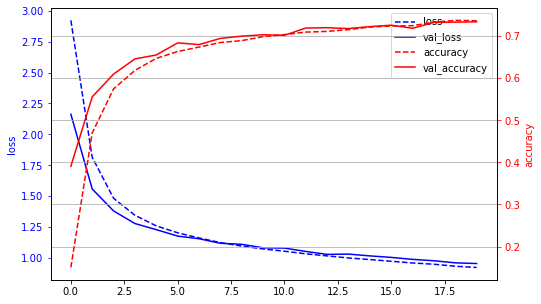

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

his = history.history 
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['loss'], 'b--',label='loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['accuracy'], 'r--',label='accuracy')
ln4 = ax2.plot(his['val_accuracy'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4 
labels = [l.get_label() for l in lns]
ax.legend(lns, labels)
plt.grid(True)
plt.show()

To visualize using Tensorboard on the same jupyter notebook, we first need to load the TensorBoard extension. Then just calling the tensorboard with log file directory. 

In [25]:
%load_ext tensorboard
%tensorboard --logdir tf_logs

Reusing TensorBoard on port 6006 (pid 4200), started 0:22:06 ago. (Use '!kill 4200' to kill it.)

In [27]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir tf_logs (started 0:22:22 ago; pid 4200)


In [28]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir tf_logs (started 0:22:22 ago; port 6006, pid 4200).


#### <span style="color:#0b486b">6. Playing around with different optimizers</span>
In the following code, we try different optimizers to find the optimal one which has the best performance (evaluated on the validation set). 
It can be done easily by passing an specific optimizer when compiling model. 


In [30]:
optimizer_names = ["Nadam", "Adam", "Adadelta", "Adagrad", "RMSprop", "SGD"]
optimizer_list = [keras.optimizers.Nadam(learning_rate=0.001), keras.optimizers.Adam(learning_rate=0.001), keras.optimizers.Adadelta(learning_rate=0.001), 
                  keras.optimizers.Adagrad(learning_rate=0.001), keras.optimizers.RMSprop(learning_rate=0.001), keras.optimizers.SGD(learning_rate=0.001)]
best_acc = 0
best_i = -1
for i in range(len(optimizer_list)):
    print("*Evaluating with {}\n".format(str(optimizer_names[i])))
    dnn_model.compile(optimizer=optimizer_list[i], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dnn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid), verbose=0)
    acc = dnn_model.evaluate(X_valid, y_valid)[1]
    print("The valid accuracy is {}\n".format(acc))
    if acc > best_acc:
        best_acc = acc
        best_i = i
print("The best valid accuracy is {} with {}".format(best_acc, optimizer_names[best_i]))
        

*Evaluating with Nadam

1500/1500 [==============================] - 0s 16us/sample - loss: 0.6324 - accuracy: 0.8093
The valid accuracy is 0.809333324432373

*Evaluating with Adam

1500/1500 [==============================] - 0s 18us/sample - loss: 0.6159 - accuracy: 0.8160
The valid accuracy is 0.8159999847412109

*Evaluating with Adadelta

1500/1500 [==============================] - 0s 18us/sample - loss: 0.6089 - accuracy: 0.8193
The valid accuracy is 0.8193333148956299

*Evaluating with Adagrad

1500/1500 [==============================] - 0s 14us/sample - loss: 0.6056 - accuracy: 0.8193
The valid accuracy is 0.8193333148956299

*Evaluating with RMSprop

1500/1500 [==============================] - 0s 24us/sample - loss: 0.6163 - accuracy: 0.8180
The valid accuracy is 0.8180000185966492

*Evaluating with SGD

1500/1500 [==============================] - 0s 14us/sample - loss: 0.6091 - accuracy: 0.8227
The valid accuracy is 0.8226666450500488

The best valid accuracy is 0.82266664

#### <span style="color:#0b486b">7. Fine-tuning the learning rate</span>
Learning rate plays an important role when training a deep learning model. In the following code, we will try a simple greedy search to find a good learning rate. 

In [31]:
lr = [1e-2, 5e-3, 1e-3, 1e-4, 1e-5]

best_acc = 0
best_i = -1
for i in range(len(lr)):
    print("*Evaluating with learning rate = {}\n".format(str(lr[i])))
    dnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr[i]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dnn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid), verbose=0)
    acc = dnn_model.evaluate(X_valid, y_valid)[1]
    print("The valid accuracy is {}\n".format(acc))
    if acc > best_acc:
        best_acc = acc
        best_i = i
print("The best valid accuracy is {} with learning rate {}".format(best_acc, lr[best_i]))

*Evaluating with learning rate = 0.01

1500/1500 [==============================] - 0s 10us/sample - loss: 0.6443 - accuracy: 0.8033
The valid accuracy is 0.8033333420753479

*Evaluating with learning rate = 0.005

1500/1500 [==============================] - 0s 13us/sample - loss: 0.5313 - accuracy: 0.8387
The valid accuracy is 0.8386666774749756

*Evaluating with learning rate = 0.001

1500/1500 [==============================] - 0s 17us/sample - loss: 0.5038 - accuracy: 0.8533
The valid accuracy is 0.8533333539962769

*Evaluating with learning rate = 0.0001

1500/1500 [==============================] - 0s 11us/sample - loss: 0.4901 - accuracy: 0.8540
The valid accuracy is 0.8539999723434448

*Evaluating with learning rate = 1e-05

1500/1500 [==============================] - 0s 18us/sample - loss: 0.4887 - accuracy: 0.8540
The valid accuracy is 0.8539999723434448

The best valid accuracy is 0.8539999723434448 with learning rate 0.0001


#### <span style="color:#0b486b">8. Save and Load Models</span>

There are different ways to save TensorFlow models depending on the API you're using. As we used the Keras model in this tutorial, saving and loading it quite simple. It can be done by calling `model.save()` and `load_model()` methods. 
When calling `model.save()`, the entire model will be saved including: 
- The architecture, or configuration, which specifies what layers the model contain, and how they're connected.
- A set of weights values (the "state of the model").
- An optimizer (defined by compiling the model).
- A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).

In [29]:
# Saving the entire model to a directory
dnn_model.save('models/my_model.h5')

# Loading the model back 
from tensorflow import keras
loaded_model = keras.models.load_model('models/my_model.h5')

# Checking the loaded model 
print(dnn_model.predict(X_new) == loaded_model.predict(X_new))

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


#### <span style="color:#0b486b">Save model during training</span>

One major disadvantage of the above saving method is that we cannot save the model during training but only when the training is finished. Therefore, it can be the case when the training was stopped/interrupted and we have to retrain again. To save model during training process, we can use the `ModelCheckpoint` callback allows you to continually save the model both during and at the end of training. 
Some important arguments of the `ModelCheckpoint` callback: 
- `filepath`: checkpoin directory 
- `save_weights_only`: if True, then only the model's weights will be saved (i.e., equal with model.save_weights(filepath)), else the full model is saved (i.e., equal with model.save(filepath) which saves: model' weight, model architecture, optimizer, etc.)
- `save_best_only`: if True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. The "best" model is evaluated based on "mode" and "monitor". For example, if `monitor=val_accuracy` it means that validation accuracy is used to monitor the best checkpoint, and `mode` should be set to `max`. If `monitor=val_loss` it means that validation loss is used instead, and `mode` in this case should be `min`. 

More detail can be found in the link: 
https://www.tensorflow.org/tutorials/keras/save_and_load

In [33]:
# Create a tf.keras.callbacks.ModelCheckpoint callback that saves weights only during training
checkpoint_path = "./checkpoints/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Save the weights using the `checkpoint_path` format
#dnn_model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
dnn_model.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=20, 
                        validation_data=(X_valid, y_valid), 
                       callbacks=[tensorboard_callback, # Callback for writing log 
                                 cp_callback]) # Callback for saving model 


Train on 12000 samples, validate on 1500 samples
Epoch 1/20
11968/12000 [============================>.] - ETA: 0s - loss: 0.8860 - accuracy: 0.7472
Epoch 00001: saving model to ./checkpoints/cp.ckpt
12000/12000 [==============================] - 1s 70us/sample - loss: 0.8855 - accuracy: 0.7474 - val_loss: 0.9219 - val_accuracy: 0.7460
Epoch 2/20
10560/12000 [=========================>....] - ETA: 0s - loss: 0.8774 - accuracy: 0.7509
Epoch 00002: saving model to ./checkpoints/cp.ckpt
12000/12000 [==============================] - 1s 59us/sample - loss: 0.8732 - accuracy: 0.7518 - val_loss: 0.9137 - val_accuracy: 0.7427
Epoch 3/20
11904/12000 [============================>.] - ETA: 0s - loss: 0.8621 - accuracy: 0.7543
Epoch 00003: saving model to ./checkpoints/cp.ckpt
12000/12000 [==============================] - 1s 60us/sample - loss: 0.8630 - accuracy: 0.7536 - val_loss: 0.9200 - val_accuracy: 0.7373
Epoch 4/20
11872/12000 [============================>.] - ETA: 0s - loss: 0.8540 - a

#### <span style="color:#0b486b">Save model during training</span>
If we only saved the model's weight, we need to recreate a same architecture before loading the model weight. 

In [34]:
# Because we alreary created a model, therefore, we just need to load the weight 
# dnn_model = create_model() # skip this step
dnn_model.load_weights(checkpoint_path)

If we saved the entire model (by set `save_weights_only=False`), then the pretrained model can be reloaded by `load_model` method

### <span style="color:#0b486b"> II.3 Two Approaches to Build Up Models with TensorFlow 2.x</span> <span style="color:red">*** (moderately important)</span>

There are two approaches to build up a model with tensorflow 2.x, a simple method using **Sequential API** and a more flexible method using **Functional API**.  

#### <span style="color:#0b486b"> Approach 1: Using `Sequential API`</span>

In [35]:
dnn_model = Sequential()
dnn_model.add(Dense(units=10,  input_shape=(16,), activation='relu'))
dnn_model.add(Dense(units=20, activation='relu'))
dnn_model.add(Dense(units=15, activation='relu'))
dnn_model.add(Dense(units=26, activation='softmax'))
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### <span style="color:#0b486b"> Approach 2: Using `Functional API`</span>

In [36]:
X = tf.keras.layers.Input(shape=(16,)) #declare input layer
h = Dense(units=10, activation= 'relu')(X)
h = Dense(units=20, activation= 'relu')(h)
h = Dense(units=15, activation= 'relu')(h)
h = Dense(units=26, activation= 'softmax')(h)
dnn_model = tf.keras.Model(inputs= X, outputs=h)
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We can also declare a class inherited from `tf.keras.Model`

In [37]:
class MyDNN(tf.keras.Model):
    def __init__(self, n_classes= 26):
        super(MyDNN, self).__init__()
        self.n_classes = n_classes
        self.dense1 = tf.keras.layers.Dense(units=10, activation= 'relu')
        self.dense2 = tf.keras.layers.Dense(units=20, activation= 'relu')
        self.dense3 = tf.keras.layers.Dense(units=15, activation= 'relu')
        self.dense4 = tf.keras.layers.Dense(units=self.n_classes, activation= 'softmax')
    
    def call(self,X): #X is the input, method call specifies how to compute the output from the input X
        h = self.dense1(X)
        h = self.dense2(h)
        h = self.dense3(h)
        h = self.dense4(h)
        return h
dnn_model = MyDNN(n_classes= 26)
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### <span style="color:#0b486b"> II.4 Other approaches to Train a Model with TensorFlow 2.x</span> <span style="color:red">*** (moderately important)</span>

There are two main approaches to training a model with Tensorflow 2.x. The simplest method is the `fit` method as we did before. This method automatically helps us to process data when training (e.g., split an entire dataset into multiple mini-batches), applies callback methods such as saving model or writing TensorBoard and monitors validation performance. 

However, some projects require more handly on training process (for example, doing data augmentation in self-supervised learning or training a generative model that we will learn later in this unit). In this case, we need an ability/understanding to train a model manually. In Tensorflow 2.X, we can do that with `train_on_batch` method. Basically, we will need to *(1) manually split entire dataset into mini-batches and applied data augmentaion (if any)* and *(2) feed training data to `train_on_batch` method*. It returns a training loss (which is pre-defined when compiling model) and an updated model. 

The following code is a simple example (without any data-augmentation). 

In [38]:
n_epochs =20
batch_size = 64
for epoch in range(n_epochs):
    for idx_start in range(0, X_train.shape[0], batch_size):
        idx_end = min(X_train.shape[0], idx_start + batch_size)
        X_batch, y_batch = X_train[idx_start:idx_end], y_train[idx_start:idx_end]
        train_loss_batch = dnn_model.train_on_batch(X_batch, y_batch)  #return the batch loss
        
    train_loss, train_acc = dnn_model.evaluate(x= X_train, y= y_train, batch_size= 64, verbose= 0)
    valid_loss, valid_acc = dnn_model.evaluate(x= X_valid, y= y_valid, batch_size= 64, verbose= 0)
    print('Epoch {}: train acc={:.4f}, train loss={:.4f} | valid acc={:.4f}, valid loss= {:.4f}'.format(epoch +1, 
                                                                                                        train_acc, 
                                                                                                        train_loss, 
                                                                                                        valid_acc, 
                                                                                                        valid_loss))

Epoch 1: train acc=0.1887, train loss=2.7509 | valid acc=0.2093, valid loss= 2.7324
Epoch 2: train acc=0.2895, train loss=2.2996 | valid acc=0.2960, valid loss= 2.2943
Epoch 3: train acc=0.3925, train loss=2.0406 | valid acc=0.3940, valid loss= 2.0456
Epoch 4: train acc=0.4502, train loss=1.8343 | valid acc=0.4547, valid loss= 1.8526
Epoch 5: train acc=0.5048, train loss=1.6744 | valid acc=0.5053, valid loss= 1.7030
Epoch 6: train acc=0.5466, train loss=1.5491 | valid acc=0.5360, valid loss= 1.5848
Epoch 7: train acc=0.5839, train loss=1.4383 | valid acc=0.5780, valid loss= 1.4798
Epoch 8: train acc=0.6158, train loss=1.3343 | valid acc=0.6020, valid loss= 1.3766
Epoch 9: train acc=0.6431, train loss=1.2398 | valid acc=0.6293, valid loss= 1.2817
Epoch 10: train acc=0.6686, train loss=1.1601 | valid acc=0.6513, valid loss= 1.2032
Epoch 11: train acc=0.6864, train loss=1.0942 | valid acc=0.6647, valid loss= 1.1398
Epoch 12: train acc=0.7018, train loss=1.0396 | valid acc=0.6753, valid lo

### <span style="color:#0b486b"> Additional Exercises </span> 

1. Write your own code to save a trained model to the hard disk and restore this model, then use the restored model to output the prediction result on the test set.

2. Insert new code to the above code to enable outputting to TensorBoard the values of `training loss`, `training accuracy`, `valid loss`, and `valid accuracy` at the end of epochs. You can refer to the code [here](https://www.tensorflow.org/tensorboard/get_started).

3. Write code to do regression on the dataset `cadata` which can be downloaded [here](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html). Note that for a regression problem, you need to use the `L2` loss instead of the `cross-entropy` loss as in a classification problem. 

4. Using the problem in this tutorial, however, using a much deeper network (i.e., $16 \rightarrow 100 (ReLU) \rightarrow 200 (ReLU) \rightarrow 200 (ReLU) \rightarrow 100 (ReLu) \rightarrow 26$). Applying callback methods to save the model on training and writing a TensorBoard. Visualize `training loss`, `training accuracy`, `valid loss`, and `valid accuracy`. Provide observation and explanation of any issue if happen (hint, overfitting issue). 

5. Build up a more complex feedforward neural network with `Functional API` method  as shown in figure below. The network splits into two branches and then merges in the last layer. The concatenate operation is in the last dimenstion (for example, two arrays [10,15], [10,15] will be concatenated to an array [10,30].

<img src="./images/feed-forward-2branches.PNG" width="1000">

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>